In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

In [8]:
df = pd.read_csv('wine-reviews.csv', usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


(array([ 1089.,  4861., 16010., 29533., 29433., 26769., 16102.,  5293.,
          752.,   129.]),
 array([ 80.,  82.,  84.,  86.,  88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <BarContainer object of 10 artists>)

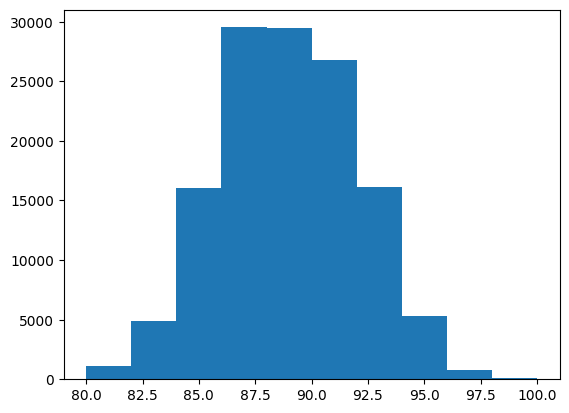

In [9]:
plt.hist(x=df['points'])

In [13]:
df['label'] = (df.points >=90).astype(int)
df = df[['description', 'label' ]]

In [14]:
df.head()

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0


In [15]:
df.tail()

,description,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1
129970,"Big, rich and off-dry, this is powered by inte...",1


In [16]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

f:\Deep learning Projects\DLenv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [17]:
train.shape, val.shape, test.shape

((103976, 2), (12997, 2), (12998, 2))

In [22]:
train

,description,label
32551,You can't help but fall in love with Brigaldar...,1
2201,This solidly good block selection shows shy ar...,0
36698,"This wine is textured, with a firm backdrop to...",1
25494,"Briary, minty berry aromas are highly herbal a...",0
84409,Gratien & Meyer's top cuvée is aged in the cav...,1
...,...,...
95805,"Made entirely with Sangiovese, this offers aro...",1
74350,Heavy toast aromas follow through to a wine th...,0
79941,"A blend of 74% Cabernet Sauvignon, 18% Syrah, ...",1
99321,A hint of caramelized apple clings to the nose...,1


In [44]:
def df_to_dataset(dataframe , shuffle= True, batch_size= 1024):
    df = dataframe.copy()
    labels = df.pop('label')
    df = df['description']
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size= len(dataframe))
    ds= ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [45]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [47]:
list(train_data)

[(<tf.Tensor: shape=(1024,), dtype=string, numpy=
  array([b"After nothing but busts in the past, this S\xc3\xa9millon is in good shape but won't stay fresh for long. Aromas of hay and stalky fruits are a bit strained. In the mouth, it's got good feel and flavors of nectarine and grapefruit. Bitter almond skin flavors control the finish on this textured, warm wine.",
         b"This vineyard site, like many others in Green Valley, was once planted to Gravenstein apples. That heritage persists in this wine's tartness that highlights an earthiness of sassafras, pomegranate and even citrus, bright elements atop a velvety-smooth texture.",
         b"A lot is going on up front; there's cassis, raisin, prune and dill aromas. Medium to full in the mouth, with lively berry, plum and spice flavors. Not too sweet and fairly long and earthy on the finish. A pure example of Rioja Reserva.",
         ...,
         b'Notes of pineapple and verbena tisane hint at some maturity. While the nose sugges

In [56]:
hub_layer = hub.KerasLayer(
    "https://tfhub.dev/google/nnlm-en-dim50/2",  
    dtype=tf.string, 
    trainable=True
)


In [70]:
model = tf.keras.Sequential([
     tf.keras.layers.Lambda(lambda x: hub_layer(x)),
     tf.keras.layers.Dense(16, activation='relu'),
     tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dropout(0.4),
     tf.keras.layers.Dense(1, activation='sigmoid')
])

In [71]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [72]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [73]:
model.evaluate(train_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3890 - loss: 0.7071


[0.7069709300994873, 0.3903977870941162]

In [64]:
model.evaluate(val_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3892 - loss: 0.7401


[0.740558922290802, 0.3863968551158905]

In [74]:
history = model.fit(train_data, epochs=50, validation_data=val_data)

Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5525 - loss: 0.6863 - val_accuracy: 0.6194 - val_loss: 0.6565
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6249 - loss: 0.6553 - val_accuracy: 0.6231 - val_loss: 0.6365
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6376 - loss: 0.6388 - val_accuracy: 0.6617 - val_loss: 0.6169
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6470 - loss: 0.6246 - val_accuracy: 0.6790 - val_loss: 0.6039
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6536 - loss: 0.6170 - val_accuracy: 0.6849 - val_loss: 0.5964
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6571 - loss: 0.6103 - val_accuracy: 0.6888 - val_loss: 0.5908
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6689 - loss: 0.6046 - val_accuracy: 0.6898 - val_loss: 0.5869
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6737 - loss: 0.6002 - val_accu

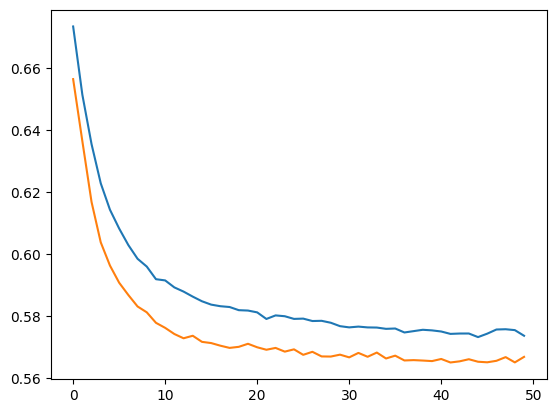

In [75]:
plt.plot(history.history['loss'], label = "Training acc")
plt.plot(history.history['val_loss'])

In [76]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7174 - loss: 0.5596


[0.5612894892692566, 0.7165718078613281]

In [77]:
## Lstm

encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text , label:text))

In [79]:
np.array(encoder.get_vocabulary())

array(['', '[UNK]', 'and', ..., 'readytodrink', 'peels', 'consistency'],
      dtype='<U17')

In [83]:
model = tf.keras.Sequential([
    encoder, 
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim = 32, 
        mask_zero = True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [85]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [86]:
model.evaluate(train_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - accuracy: 0.3864 - loss: 0.6944


[0.6944528222084045, 0.38607949018478394]

In [87]:
history = model.fit(train_data, epochs=5, validation_data=val_data)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 38s 315ms/step - accuracy: 0.6525 - loss: 0.6184 - val_accuracy: 0.8202 - val_loss: 0.3862
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 35s 342ms/step - accuracy: 0.8340 - loss: 0.3758 - val_accuracy: 0.8345 - val_loss: 0.3602
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 33s 326ms/step - accuracy: 0.8461 - loss: 0.3523 - val_accuracy: 0.8384 - val_loss: 0.3523
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 30s 294ms/step - accuracy: 0.8493 - loss: 0.3405 - val_accuracy: 0.8385 - val_loss: 0.3506
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 31s 305ms/step - accuracy: 0.8562 - loss: 0.3311 - val_accuracy: 0.8403 - val_loss: 0.3486


In [89]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.8404 - loss: 0.3492


[0.3497944474220276, 0.8391290903091431]